<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07C%20-%20Text%20Classification%20Deep%20Learning%20Sequential%20Models%20LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification - Deep Learning Sequential Models - LSTMs


Another new and interesting approach to supervised deep learning is the use
of recurrent neural networks (RNNs) and long short-term memory networks (LSTMs)
which also considers the sequence of data (words, events and so on). These are more
advanced models than your regular fully connected deep networks and usually take
more time to train.


In [76]:
!nvidia-smi

Mon Sep 16 14:11:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    71W / 149W |   4322MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [77]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [79]:
train_df=pd.read_csv('/content/review_train.csv')
test_df=pd.read_csv('/content/review_test.csv')
train_df["source"] = "train"
test_df["source"] = "test"
dataset = pd.concat([train_df,test_df])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18532 entries, 0 to 3706
Data columns (total 4 columns):
Text         18532 non-null object
Score        18532 non-null int64
Sentiment    18532 non-null int64
source       18532 non-null object
dtypes: int64(2), object(2)
memory usage: 723.9+ KB


In [80]:
# take a peek at the data
train_df.head()

,Text,Score,Sentiment,source
0,"I got a free sample of these once, and now--we...",5,1,train
1,I used to get this Tea when I lived in Washing...,4,1,train
2,This is my all time favorite 'grab and go' sna...,5,1,train
3,This flavor is very good and unexpected. The ...,4,1,train
4,thrilled to have this assortment as i got the ...,4,1,train


In [81]:
test_df.head()

,Text,Score,Sentiment,source
0,"IF YOU LOVE THE TASTE OF LOBSTER,YOU MUST ORDE...",5,1,test
1,We are so pleased with this diaper ointment; o...,5,1,test
2,I like chewing this after meals since I don't ...,5,1,test
3,And here I thought I could only get this spice...,5,1,test
4,"I'm a huge skeptic, but after 6 months of dail...",5,1,test


In [0]:
# build train and test datasets
texts = dataset['Text'].values
sentiments = dataset['Sentiment'].values
scores = dataset['Score'].values


train_texts = texts[:17000]
train_sentiments = sentiments[:17000]
train_scores = scores[:17000]


test_texts = texts[1532:]
test_sentiments = sentiments[1532:]
test_scores = scores[1532:]

In [0]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [84]:
%%time

norm_train_texts = pre_process_corpus(train_texts)
norm_test_texts = pre_process_corpus(test_texts)

100%|██████████| 17000/17000 [00:04<00:00, 3575.23it/s]

CPU times: user 9.46 s, sys: 66.9 ms, total: 9.53 s
Wall time: 9.56 s


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [0]:
import tensorflow as tf

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

In [0]:
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_texts)

In [0]:
t.word_index['<PAD>'] = 0

In [0]:
train_sequences = t.texts_to_sequences(norm_train_texts)
test_sequences = t.texts_to_sequences(norm_test_texts)

In [89]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=39776
Number of Documents=17000


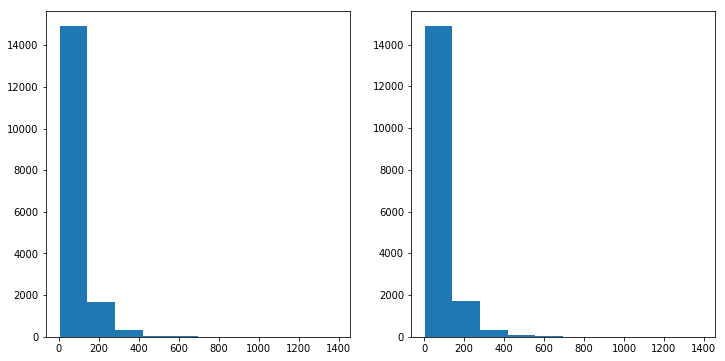

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [0]:
MAX_SEQUENCE_LENGTH = 1000

In [92]:
# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((17000, 1000), (17000, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [0]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [0]:
VOCAB_SIZE = len(t.word_index)

# LSTM Model

# Build Model Architecture


# Embeddings

The Embedding layer helps us generate the word embeddings from scratch. This layer
is also initialized with some weights and is updated based on our optimizer, similar to
weights on the neuron units in other layers when the network tries to minimize the loss
in each epoch. Thus, the embedding layer tries to optimize its weights such that we get
the best word embeddings that will generate minimum error in the model and capture
semantic similarity and relationships among words. How do we get the embeddings?
Let’s say we have a review with three terms ['movie', 'was', 'good'] and a vocab_map
consisting of word to index mappings for 175860 words. 

![](https://i.imgur.com/WuV47DW.png)


# LSTM

LSTMs try to overcome
the shortcomings of RNN models, especially with regard to handling long-term
dependencies and problems that occur when the weight matrix associated with the
units (neurons) become too small (leading to vanishing gradient) or too large (leading to
exploding gradient). These architectures are more complex than regular deep networks
and going into detailed internals and math concepts are out of the current scope, but we
will try to cover the essentials here without making it math heavy

![](https://i.imgur.com/c8qGKX8.png)

The sequence of operations in the LSTM cell is briefly shown as follows.

![](https://i.imgur.com/uiIbDk1.png)

In [96]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.SpatialDropout1D(0.1))
model.add(tf.keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=False))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 300)         11932800  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 1000, 300)         0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 128)               220160    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 12,186,241
Trainable params: 12,186,241
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [97]:
batch_size = 100
model.fit(X_train, y_train, epochs=2, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Train on 15300 samples, validate on 1700 samples
Epoch 1/2
15300/15300 [==============================] - 37s 2ms/sample - loss: 0.3400 - acc: 0.8692 - val_loss: 0.2254 - val_acc: 0.9106
Epoch 2/2
15300/15300 [==============================] - 36s 2ms/sample - loss: 0.1595 - acc: 0.9412 - val_loss: 0.2843 - val_acc: 0.9129


## Evaluate Model Performance

In [98]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

17000/17000 [==============================] - 27s 2ms/sample - loss: 0.1606 - acc: 0.9422
Accuracy: 94.22%


In [106]:
predictions = model.predict_classes(X_test).ravel()
predictions[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [100]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive']

In [107]:
from sklearn.metrics import confusion_matrix, classification_report
labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.98      0.64      0.78      2652
           1       0.94      1.00      0.97     14348

    accuracy                           0.94     17000
   macro avg       0.96      0.82      0.87     17000
weighted avg       0.94      0.94      0.94     17000



,negative,positive
negative,1706,946
positive,37,14311


# Stacked LSTM Model

## Build Model Architecture

In [108]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model2.add(tf.keras.layers.SpatialDropout1D(0.1))
model2.add(tf.keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=True))
model2.add(tf.keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=False))
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 300)         11932800  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 1000, 300)         0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 1000, 128)         220160    
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 12,318,337
Trainable params: 12,318,337
Non-trainable params: 0
__________________________________________

## Train Model

In [109]:
batch_size = 100
model2.fit(X_train, y_train, epochs=2, batch_size=batch_size, 
           shuffle=True, validation_split=0.1, verbose=1)

Train on 15300 samples, validate on 1700 samples
Epoch 1/2
15300/15300 [==============================] - 64s 4ms/sample - loss: 0.3174 - acc: 0.8758 - val_loss: 0.2157 - val_acc: 0.9182
Epoch 2/2
15300/15300 [==============================] - 63s 4ms/sample - loss: 0.1465 - acc: 0.9446 - val_loss: 0.1999 - val_acc: 0.9200


## Evaluate Model Performance

In [110]:
# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

17000/17000 [==============================] - 53s 3ms/sample - loss: 0.0970 - acc: 0.9686
Accuracy: 96.86%


In [114]:
predictions = model2.predict_classes(X_test).ravel()
predictions[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [112]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive']

In [115]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      2652
           1       0.98      0.99      0.98     14348

    accuracy                           0.97     17000
   macro avg       0.95      0.93      0.94     17000
weighted avg       0.97      0.97      0.97     17000



,negative,positive
negative,2318,334
positive,199,14149
